## 0. Basic

### Display the some first `image_file_names` & `file_name.csv`

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

## print out the names of the first 5 image_files (total = 10 images for train_imgaes & train_label_masks) with the train, test, submission.csv files & 5 file.hdf5
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:5]:
        print(os.path.join(dirname, filename))

/kaggle/input/pytable-hdf/img_dtbase_3000.h5
/kaggle/input/pytable-hdf/img_dtbase_250.h5
/kaggle/input/pytable-hdf/img_dtbase_8750.h5
/kaggle/input/pytable-hdf/img_dtbase_10000.h5
/kaggle/input/pytable-hdf/img_dtbase_6250.h5
/kaggle/input/prostate-cancer-grade-assessment/sample_submission.csv
/kaggle/input/prostate-cancer-grade-assessment/test.csv
/kaggle/input/prostate-cancer-grade-assessment/train.csv
/kaggle/input/prostate-cancer-grade-assessment/train_images/2673584f9398ce0acb21a86a1a711088.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/5d46da93924a4b15472581eb39658309.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/35e8dd323072ad8efa1ae1db44921669.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/a807e743ad2020d229347aede1882a8f.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/95c518378ccd428a5e674c3c668e9f2e.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/9bce8bb47c22ab502ed7266e2e3762c0_mask.

### Basic libraries

In [2]:
import os

# There are two ways to load the data from the PANDA dataset:
# Option 1: Load images using openslide
import openslide
# Option 2: Load images using skimage (requires that tifffile is installed)
import skimage.io
import random
import seaborn as sns
import cv2

# General packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL
from IPython.display import Image, display

# Plotly for the interactive viewer (see last section)
import plotly.graph_objs as go

### Loading & viewing dataset

In [3]:
# Location of the training images

BASE_PATH = '../input/prostate-cancer-grade-assessment'

# image and mask directories
data_dir = f'{BASE_PATH}/train_images'
mask_dir = f'{BASE_PATH}/train_label_masks'


# Location of training labels
train = pd.read_csv(f'{BASE_PATH}/train.csv').set_index('image_id')
test = pd.read_csv(f'{BASE_PATH}/test.csv')

train_labels = pd.read_csv('/kaggle/input/prostate-cancer-grade-assessment/train.csv').set_index('image_id')

submission = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')

In [4]:
train.head()

,data_provider,isup_grade,gleason_score
image_id,,,
0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [5]:
print("Shape of training data :", train.shape)
print("Mainly information of training data :", train.info())
print("unique data provider :", len(train.data_provider.unique()))
print("unique isup_grade(target) :", len(train.isup_grade.unique()))
print("unique gleason_score :", len(train.gleason_score.unique()))

Shape of training data : (10616, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 10616 entries, 0005f7aaab2800f6170c399693a96917 to ffe9bcababc858e04840669e788065a1
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   data_provider  10616 non-null  object
 1   isup_grade     10616 non-null  int64 
 2   gleason_score  10616 non-null  object
dtypes: int64(1), object(2)
memory usage: 331.8+ KB
Mainly information of training data : None
unique data provider : 2
unique isup_grade(target) : 6
unique gleason_score : 11


In [6]:
os.listdir(data_dir)[:5]

['2673584f9398ce0acb21a86a1a711088.tiff',
 '5d46da93924a4b15472581eb39658309.tiff',
 '35e8dd323072ad8efa1ae1db44921669.tiff',
 'a807e743ad2020d229347aede1882a8f.tiff',
 '95c518378ccd428a5e674c3c668e9f2e.tiff']

In [7]:
len(os.listdir(data_dir)), len(os.listdir(mask_dir))

(10616, 10516)

In [8]:
data_dirname = [name.replace('.tiff', '') for name in os.listdir(data_dir)]
mask_dirname = [name.replace('_mask.tiff', '') for name in os.listdir(mask_dir)]

len(data_dirname), len(mask_dirname)

(10616, 10516)

In [9]:
data_dirname[:5], mask_dirname[:5]

(['2673584f9398ce0acb21a86a1a711088',
  '5d46da93924a4b15472581eb39658309',
  '35e8dd323072ad8efa1ae1db44921669',
  'a807e743ad2020d229347aede1882a8f',
  '95c518378ccd428a5e674c3c668e9f2e'],
 ['9bce8bb47c22ab502ed7266e2e3762c0',
  '124a0616099409f5b9aaedfd3ac3ab6d',
  '8b1590bb6429c7b3bbbcf0a420fff72d',
  '106bc932dfebc6ffb887fe799f01caab',
  'afaa3f61f49c3e47bbfa02f3d657994f'])

In [10]:
C = set(data_dirname) - (set(data_dirname) - set(mask_dirname))
images_test_list = list(C)
len(images_test_list)
print(images_test_list[:3])

['756d99387536d5721fcf4cf590627179', 'db55ba974934917c0fd582f2dd7a109c', '2364e13161b373f7d463220e68eea803']


In [11]:
test.head()

,image_id,data_provider
0,005700be7e06878e6605e7a5a39de1b2,radboud
1,005c6e8877caf724c600fdce5d417d40,karolinska
2,0104f76634ff89bfff1ef0804a95c380,radboud


In [12]:
submission.head()

,image_id,isup_grade
0,005700be7e06878e6605e7a5a39de1b2,0
1,005c6e8877caf724c600fdce5d417d40,0
2,0104f76634ff89bfff1ef0804a95c380,0


### 3. Build `get_tiles` function with `n_tiles = 81`

Target: Extract `tiles` & `coresponding masks_img` simultaneous!!

In [13]:
tile_size = 256; mode = 0
h = 22321
w = 9000
pad_h = (tile_size - h % tile_size) % tile_size + ((tile_size * mode) // 2)
pad_w = pad_h
si = [[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2,pad_w - pad_w//2], [0,0]]
print(si)
pad_h

[[103, 104], [103, 104], [0, 0]]


207

In [14]:
from skimage.transform import rescale, resize
def get_tiles_with_id(img_id, level, mode=0, n_tiles = 81, ops = 256):
        """
            Input: 
                    - img_id (str): image_id from the train dataset
                    - level (int): an integer in {0, 1, 2} corresponding to the level_downsamples {1, 4, 16}
                    - mode (int) : define the quantities of pad_height & pad_width
                    - n_tiles (int): number of tiles (must be a squared_number)
                    - ops (int) : output_size of each image
            return: 
                    - list of img_data_tiles
                    - img_mask
                    - bool
        """
        tile_size = int(256 / 2**(2*level))
        data_img = skimage.io.MultiImage(os.path.join(data_dir, f'{img_id}.tiff'))[level]
        mask_img = skimage.io.MultiImage(os.path.join(mask_dir, f'{img_id}_mask.tiff'))[level]
        
        image_data_ls = []; image_mask_ls = []
        
        h, w = data_img.shape[:2]
        pad_h = (tile_size - h % tile_size) % tile_size + ((tile_size * mode) // 2)
        pad_w = (tile_size - w % tile_size) % tile_size + ((tile_size * mode) // 2)
        
        img2_dt_ = np.pad(data_img,[[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2,pad_w - pad_w//2], [0,0]], constant_values = 255)
        img2_ms_ = np.pad(mask_img,[[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2,pad_w - pad_w//2], [0,0]], constant_values = mask_img.max())
        
        img3_dt_ = img2_dt_.reshape(img2_dt_.shape[0] // tile_size, tile_size,
                                    img2_dt_.shape[1] // tile_size, tile_size,
                                    3 )
        img3_ms_ = img2_ms_.reshape(img2_ms_.shape[0] // tile_size, tile_size,
                                    img2_ms_.shape[1] // tile_size, tile_size,
                                    3 )
        
        img3_dt_ = img3_dt_.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size,3)
        img3_ms_ = img3_ms_.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size,3)
        
        n_tiles_with_info = (img3_dt_.reshape(img3_dt_.shape[0],-1).sum(1) < tile_size ** 2 * 3 * 255).sum()
        
        if len(data_img) < n_tiles:
            img3_dt_ = np.pad(img3_dt_,[[0,N - len(img3_dt_)],[0,0],[0,0],[0,0]], constant_values=255)
            img3_ms_ = np.pad(img3_ms_,[[0,N - len(img3_ms_)],[0,0],[0,0],[0,0]], constant_values = mask_img.max())
            
        idxs_dt_ = np.argsort(img3_dt_.reshape(img3_dt_.shape[0],-1).sum(-1))[:n_tiles]    
        
        img3_dt_ = img3_dt_[idxs_dt_]
        img3_ms_ = img3_ms_[idxs_dt_]
        
        
        for i in range(len(img3_dt_)):
            img4_dt_ = cv2.resize(img3_dt_[i], (ops, ops))
            image_data_ls.append({'img':img4_dt_, 'idx':i})
            img4_ms_ = cv2.resize(img3_ms_[i], (ops, ops))
            image_mask_ls.append({'img':img4_ms_, 'idx':i})
            del img4_dt_, img4_ms_
        return image_data_ls, image_mask_ls, n_tiles_with_info >= n_tiles
    

%time z = get_tiles_with_id('004dd32d9cd167d9cc31c13b704498af', 1); 
type(z), z[0][0]['img'].min(), z[0][0]['img'].max()

CPU times: user 262 ms, sys: 76.8 ms, total: 339 ms
Wall time: 388 ms


(tuple, 1, 255)

In [15]:
type(z[0]), len(z[0]), type(z[1]), len(z[1]), type(z[-1]), type(z[0][1])

(list, 81, list, 81, numpy.bool_, dict)

In [16]:
z[-1]

True

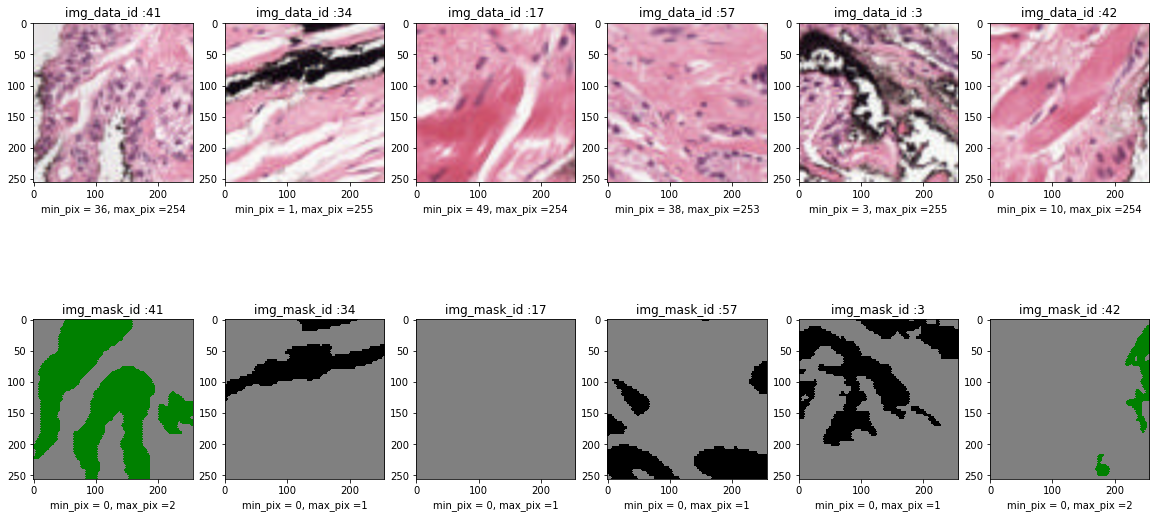

In [17]:
cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
plt.figure(figsize = (20, 10))
for k in range(6):
    idx = np.random.randint(0, len(z[0]))
    plt.subplot(2,6,k+1), plt.title('img_data_id :'+str(idx))
    plt.imshow(z[0][idx]['img'])
    plt.xlabel('min_pix = ' + str(z[0][idx]['img'].min()) + ', max_pix =' + str(z[0][idx]['img'].max()))
    
    plt.subplot(2,6,k+7), plt.title('img_mask_id :'+str(idx))
    plt.imshow(z[1][idx]['img'][:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5)
    plt.xlabel('min_pix = ' + str(z[1][idx]['img'].min()) + ', max_pix =' + str(z[1][idx]['img'].max()))

## 2. Create database

### 4.1. pytable & hdf5 libraries

In [18]:
import tables
import h5py
import deepdish as dd
images_test_list[:10]

['756d99387536d5721fcf4cf590627179',
 'db55ba974934917c0fd582f2dd7a109c',
 '2364e13161b373f7d463220e68eea803',
 '877b69359277cf787d93cd17f4d2775a',
 'dd1db5cd5fad82faf3ae68a17696e31e',
 'd0c4142647b620df5a8b8e5e21f970e1',
 'd3bec5f291e147ae2527e00f897c6229',
 '613d47883d333e9a07f1347ffc64e7ab',
 '9269a7b94ac73d384512a87c1b38fd5a',
 '875a9828eae84e015c5ed0e2fdd76b8e']

In [19]:
import tables
import h5py
from sys import getsizeof
import deepdish as dd

#### 4.2. Create `pytable`

## Notes: Dòng dưới này tao đã lưu lại và khóa rồi; đừng chạy lại nữa

In [20]:
def get_image(img_id_ls, level):
        """
            Input: 
                    - img_id (str): image_id from the train dataset
                    - level (int): an integer in {0, 1, 2} corresponding to the level_downsamples {1, 4, 16}
            return: 
                    - list of img_data & img_mask
        """
        
        img_data_list, img_mask_list = [], []
        for img_id in img_id_ls:
            data_img = skimage.io.MultiImage(os.path.join(data_dir, f'{img_id}.tiff'))[level]
            mask_img = skimage.io.MultiImage(os.path.join(mask_dir, f'{img_id}_mask.tiff'))[level]
            
            img_data_list.append(data_img) 
            img_mask_list.append(mask_img)
            del data_img, mask_img
        return img_data_list, img_mask_list, img_id_ls

%time img_dt, img_msk, im_id = get_image(images_test_list[10250: ], 2)
# dic = {'img_data': img_dt, 'img_mask': img_msk, 'img_id': im_id}
# dd.io.save(file_name.h5, data = dic, compression=('blosc', 9))

CPU times: user 6.3 s, sys: 2.05 s, total: 8.35 s
Wall time: 14.8 s


In [21]:
import os
pytab_dir = '/kaggle/input/pytable-hdf'
pytab_data = os.listdir(pytab_dir)
pytab_data[: 5]

['img_dtbase_3000.h5',
 'img_dtbase_250.h5',
 'img_dtbase_8750.h5',
 'img_dtbase_10000.h5',
 'img_dtbase_6250.h5']

Note: The files in this `pytab_dir` has a form: 

                        img_dtbase  +  _number + .h5
                        
For example; the filename:

- `img_dtbase_250.h5` is corresponding to the first 250 images_id in `img_id_mutual_name`

- `img_dtbase_2500.h5` is corresponding to the element images_id 2250 to 2500 in `img_id_mutual_name`

- `img_dtbase_10516.h5` is corresponding to the element images_id 10250 to 10516 in `img_id_mutual_name`

### 3. Structure_data in each `file.h5`

In [22]:
X1 = dd.io.load('/kaggle/input/pytable-hdf/img_dtbase_250.h5')
type(X1), type(X1['img_data']), type(X1['img_mask']), type(X1['img_id'])

(dict, list, list, list)

Each file `.h5` is a dictionary contained 3 lists: `"img_data", "img_mask"` and `"img_id"`

In [23]:
X1['img_data'][0].shape, X1['img_mask'][0].shape

((544, 192, 3), (544, 192, 3))

(<matplotlib.axes._subplots.AxesSubplot at 0x7ff5341f0550>,
 Text(0.5, 1.0, 'img_mask_id : b368187a74f04f31a73030862c85e1b6'))

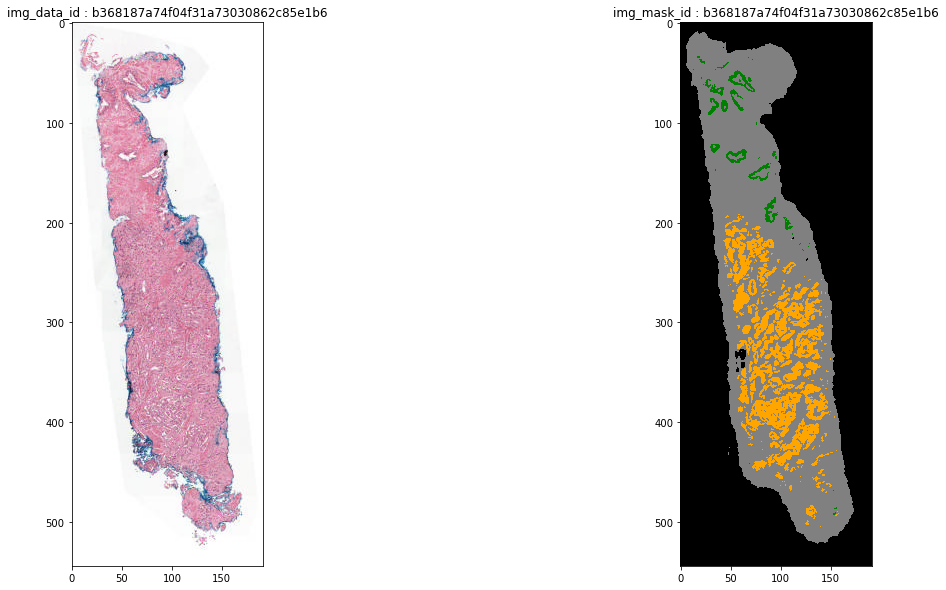

In [24]:
a, b, title = X1['img_data'][0], X1['img_mask'][0], X1['img_id'][0]

cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
plt.figure(figsize = (20, 10))
plt.subplot(121), plt.imshow(a), plt.title('img_data_id : ' + title)
plt.subplot(122), plt.imshow(b[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5), plt.title('img_mask_id : ' + title)

In [28]:
from skimage.transform import rescale, resize
def get_tiles_image(data_img, mask_img, level=2, mode=0, n_tiles = 36, ops = 256):
        """
            Input: 
                    - img_id (str): image_id from the train dataset
                    - level (int): an integer in {0, 1, 2} corresponding to the level_downsamples {1, 4, 16}
                    - mode (int) : define the quantities of pad_height & pad_width
                    - n_tiles (int): number of tiles (must be a squared_number)
                    - ops (int) : output_size of each image
            return: 
                    - list of img_data_tiles
                    - img_mask
                    - bool
        """
        tile_size = 256
        h, w = data_img.shape[: 2]
        data_img = cv2.resize(data_img, (16*h, 16*w))
        mask_img = cv2.resize(mask_img, (16*h, 16*w))
        
        image_data_ls = []; image_mask_ls = []
        
        h, w = data_img.shape[:2]
        pad_h = (tile_size - h % tile_size) % tile_size + ((tile_size * mode) // 2)
        pad_w = (tile_size - w % tile_size) % tile_size + ((tile_size * mode) // 2)
        
        img2_dt_ = np.pad(data_img,[[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2,pad_w - pad_w//2], [0,0]], constant_values = 255)
        img2_ms_ = np.pad(mask_img,[[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2,pad_w - pad_w//2], [0,0]], constant_values = mask_img.max())
        
        img3_dt_ = img2_dt_.reshape(img2_dt_.shape[0] // tile_size, tile_size,
                                    img2_dt_.shape[1] // tile_size, tile_size,
                                    3 )
        img3_ms_ = img2_ms_.reshape(img2_ms_.shape[0] // tile_size, tile_size,
                                    img2_ms_.shape[1] // tile_size, tile_size,
                                    3 )
        
        img3_dt_ = img3_dt_.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size,3)
        img3_ms_ = img3_ms_.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size,3)
        
        n_tiles_with_info = (img3_dt_.reshape(img3_dt_.shape[0],-1).sum(1) < tile_size ** 2 * 3 * 255).sum()
        
        if len(data_img) < n_tiles:
            img3_dt_ = np.pad(img3_dt_,[[0,N - len(img3_dt_)],[0,0],[0,0],[0,0]], constant_values=255)
            img3_ms_ = np.pad(img3_ms_,[[0,N - len(img3_ms_)],[0,0],[0,0],[0,0]], constant_values = mask_img.max())
            
        idxs_dt_ = np.argsort(img3_dt_.reshape(img3_dt_.shape[0],-1).sum(-1))[:n_tiles]    
        
        img3_dt_ = img3_dt_[idxs_dt_]
        img3_ms_ = img3_ms_[idxs_dt_]
        
        
        for i in range(len(img3_dt_)):
            img4_dt_ = cv2.resize(img3_dt_[i], (ops, ops))
            image_data_ls.append({'img':img4_dt_, 'idx':i})
            img4_ms_ = cv2.resize(img3_ms_[i], (ops, ops))
            image_mask_ls.append({'img':img4_ms_, 'idx':i})
            del img4_dt_, img4_ms_
        return image_data_ls, image_mask_ls, n_tiles_with_info >= n_tiles

### Loading `tiles_image` with `get_tiles_image`

In [29]:
z = get_tiles_image(a, b)
cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
plt.figure(figsize = (20, 10))
for k in range(6):
    idx = np.random.randint(0, len(z[0]))
    plt.subplot(2,6,k+1), plt.title('img_data_id :'+str(idx))
    plt.imshow(z[0][idx]['img'])
    plt.xlabel('min_pix = ' + str(z[0][idx]['img'].min()) + ', max_pix =' + str(z[0][idx]['img'].max()))
    
    plt.subplot(2,6,k+7), plt.title('img_mask_id :'+str(idx))
    plt.imshow(z[1][idx]['img'][:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5)
    plt.xlabel('min_pix = ' + str(z[1][idx]['img'].min()) + ', max_pix =' + str(z[1][idx]['img'].max()))

ValueError: too many values to unpack (expected 2)

To find a link

In [27]:
X = {'a': [1, 2, 3, 4, 4], 'b' : [1, 2, 4]}
dd.io.save('draft.h5', data = X)

import os
from IPython.display import FileLink
FileLink('draft.h5')

/opt/conda/lib/python3.7/site-packages/deepdish/io/hdf5io.py:251: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


/kaggle/working/draft.h5